In [1]:
#!git clone https://github.com/axelcarlier/animals.git
!git clone https://github.com/echigot/deep-learning-3A.git

Cloning into 'deep-learning-3A'...
remote: Enumerating objects: 50835, done.
remote: Counting objects: 100% (50835/50835), done.
remote: Compressing objects: 100% (49303/49303), done.
remote: Total 50835 (delta 556), reused 50830 (delta 551), pack-reused 0
Receiving objects: 100% (50835/50835), 77.31 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (556/556), done.
Checking out files: 100% (51322/51322), done.


In [2]:
IMAGE_SIZE = 64 # Dimension des images en entrée du réseau
CELL_PER_DIM = 8 # Nombre de cellules en largeur et en hauteur
NB_CLASSES = 10 # Nombre de classes du problème
PIX_PER_CELL = IMAGE_SIZE/CELL_PER_DIM
#DATASET_SIZE = 1200
#DATASET_SIZE = 1044
BOX_PER_CELL = 1 # Code à modifier pour avoir plusieurs animaux par cellule ?

In [3]:
import PIL
from PIL import Image
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import math
%matplotlib inline

import keras
from keras.utils import np_utils


# Chemin vers la base de données
#path = "./animals/unlabelled/"
path = "./deep-learning-3A/animals-master/labelled/"
# Parcours des fichiers (classés) du répertoire
dirs = os.listdir(path)
dirs.sort()
#DATASET_SIZE = len(dirs) // 2
DATASET_SIZE = 922
# Indice d'ajout de données dans les variables x et y 
i = 0
# Préparation des structures de données pour x et y
#x = np.zeros((50000, 64, 64, 3))
x = np.zeros((DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
y = np.zeros((DATASET_SIZE, CELL_PER_DIM, CELL_PER_DIM, NB_CLASSES + 5*BOX_PER_CELL))

# Sauvegarde des largeur/hauteur normalisées de bounding box
widths = []
heights = []

for item in dirs:
  # On sépare image et texte avec l'extension
  nom = item.split(".")[0]
  extension = item.split(".")[1]

  if extension=="jpg":
    if os.path.getsize(path+nom+".txt") > 1:
      ok = True
      img = Image.open(path + item)
      x[i] = np.asarray(img)
    else:
      ok = False

  if extension=="txt" and ok:
    # Texte : coordonnées de boîtes englobantes pour remplir y
    labels = open(path + item, "r")
    # Récupération des lignes du fichier texte
    labels = labels.read().split('\n')
    # Si la dernière ligne est vide, la supprimer 
    if labels[-1]=="":
      del labels[-1]

    boxes = []
    for label in labels:
      # Récupération des informations de la boîte englobante
      label = label.split()
      # Sauvegarde des largeur/hauteur de boîtes englobantes
      widths.append(float(label[3]))
      heights.append(float(label[4]))
      # Coordonnées du centre de la boîte englobante dans le repère image
      cx, cy = float(label[1]) * IMAGE_SIZE, float(label[2]) * IMAGE_SIZE
      # Détermination des indices de la cellule dans laquelle tombe le centre
      ind_x, ind_y = int(cx // PIX_PER_CELL), int(cy // PIX_PER_CELL)
      # YOLO : "The (x, y) coordinates represent the center of the box relative to the bounds of the grid cell."
      # On va donc calculer les coordonnées du centre relativement à la cellule dans laquelle il se situe
      cx_cell = (cx - ind_x * PIX_PER_CELL) / PIX_PER_CELL
      cy_cell = (cy - ind_y * PIX_PER_CELL) / PIX_PER_CELL
      # Indice de confiance de la boîte englobante
      presence = np.array([1], dtype="i")
      # "One-hot vector" représentant les probabilités de classe dans la cellule
      classes = np_utils.to_categorical(label[0], num_classes=10)
      # On range les probabilités de classe à la fin du vecteur ([ BOX 1 ; BOX 2 ; ... ; BOX N ; CLASSES])
      y[i, ind_x, ind_y, 5 * BOX_PER_CELL:] = classes

      boxes.append([cx, cy, label[3]*IMAGE_SIZE, label[4]*IMAGE_SIZE])
      # Détermination de l'indice de la boîte englobante de cellule dans laquelle ranger les informations
      ind_box = 0
      while y[i, ind_x, ind_y, 5*ind_box] == 1 and ind_box < BOX_PER_CELL - 1:
        # Si la boîte d'indice courant est déjà utilisée (présence = 1) 
        # et que l'on a pas atteint le nombre maximal de boîtes, on passe à la boîte suivante
        ind_box = ind_box + 1

      if y[i, ind_x, ind_y, 5*ind_box] == 1:
        print("ERREUR : LA CELLULE CONTIENT DEJA TOUTES LES BOITES DISPONIBLES")
        print(path + item)
      else:
        y[i, ind_x, ind_y, 5*ind_box] = 1
        y[i, ind_x, ind_y, 5*ind_box + 1] = cx_cell
        y[i, ind_x, ind_y, 5*ind_box + 2] = cy_cell
        # Racine carrée de la largeur et hauteur de boîte
        y[i, ind_x, ind_y, 5*ind_box + 3] = math.sqrt(float(label[3]))
        y[i, ind_x, ind_y, 5*ind_box + 4] = math.sqrt(float(label[4]))
        
    if ok:
      i = i+1

#print(i)

In [4]:
#i = 0
#for item in dirs:
  # Image : on va remplir la variable x
  # Lecture de l'image
  #extension = item.split(".")[1]
  #if extension=="jpg":
    #img = Image.open(path + item)
    # Remplissage de la variable x
    #x[i] = np.asarray(img)
    #i = i+1

x = x.astype('uint8')

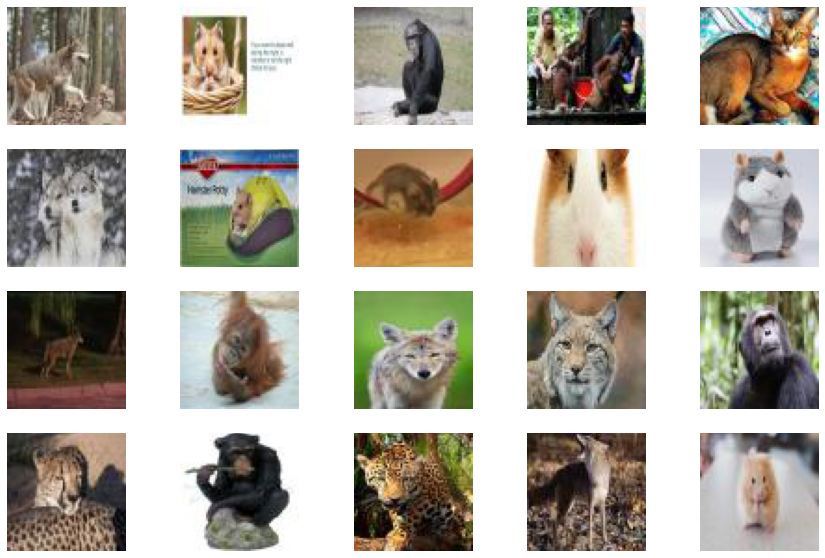

In [5]:
# Visualiser la base de données
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(15, 10))

for i in range(20):
  num = np.random.randint(x.shape[0])
  #print(y[num])
  plt.subplot(4, 5, i+1)
  plt.imshow(x[num]);
  plt.axis('off')
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

# Normalisation des images
x_train = x_train/255
x_val = x_val/255

428


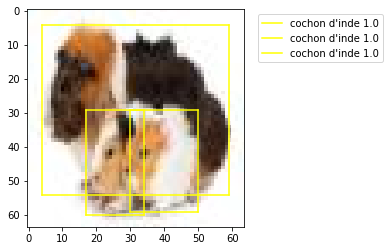

In [24]:
from scipy.special import softmax

def print_data_detection(x, y, id=None, image_size=IMAGE_SIZE, mode='gt'):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0])
    print(num_img)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange", "green", "purple", "white", "black","gray","pink"]
  classes = ["hamster","cochon d'inde","loup","coyote","chat","lynx","guépard","jaguar","orang-outan","chimpanzé"]

  boxes = lab[:, :, 1:5]
  for ind_x in range(CELL_PER_DIM):
    for ind_y in range(CELL_PER_DIM):
      box = boxes[ind_x, ind_y]
      box[0] = box[0] * PIX_PER_CELL + ind_x * PIX_PER_CELL
      box[1] = box[1] * PIX_PER_CELL + ind_y * PIX_PER_CELL
      box[2] = box[2]**2 * IMAGE_SIZE
      box[3] = box[3]**2 * IMAGE_SIZE
      boxes[ind_x, ind_y] = box

  # Récupération de toutes les informations des boîtes englobantes
  all_presences = np.reshape(lab[:, :, 0], (CELL_PER_DIM*CELL_PER_DIM))
  all_boxes = np.reshape(lab[:, :, 1:5], (-1, 4))
  all_classes = np.reshape(lab[:, :, 5:14], (-1, 9))

  if mode=='pred':
    all_presences = 1 / (1 + np.exp(-all_presences))
    all_classes = softmax(all_classes, axis=1)

  indices_sorted = np.argsort(-all_presences)
  #print(all_presences[indices_sorted[0:5]])
  #print(all_classes[indices_sorted[0:5]])

  # Eliminer toutes les boîtes englobantes dont la probabilité de presence est < 0.5 
  seuil = 0.5
  all_boxes = all_boxes[np.where(all_presences > seuil)]
  all_classes = all_classes[np.where(all_presences > seuil)]
  all_presences = all_presences[np.where(all_presences > seuil)]


  # Affichage de l'image
  plt.imshow(img)
  for i in range(all_boxes.shape[0]):

    # Détermination de la classe
    class_id = np.argmax(all_classes[i])
    lab = all_boxes[i]
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [lab[0]-lab[2]/2, lab[0]+lab[2]/2]
    p_y = [lab[1]-lab[3]/2, lab[1]+lab[3]/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id], label=classes[class_id] + " " +  str(all_presences[i]))
    #plt.title("Vérité Terrain : Image {}".format(num_img, classes[class_id]))
  
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.show()  


print_data_detection(x_train, y_train, image_size=IMAGE_SIZE)

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((783, 64, 64, 3), (783, 8, 8, 15), (139, 64, 64, 3), (139, 8, 8, 15))

In [9]:
# Pour télécharger les poids: wget

import keras
#import yolo3
from keras.models import Model
#model = load_model('model.h5')

# define the model
#model = make_yolov3_model()

# load the model weights
#weight_reader = WeightReader(path + 'yolov3.weights')

###################################
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving yolov3.weights to yolov3.weights
User uploaded file "yolov3.weights" with length 248007048 bytes


In [10]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model
 
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0
 
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [22]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
 
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = "./deep-learning-3A/animals-master/labelled/img99.jpg"
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["hamster","cochon d'inde","loup","coyote","chat","lynx","guépard","jaguar","orang-outan","chimpanzé"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

(1, 64, 64, 3)
[(1, 2, 2, 255), (1, 4, 4, 255), (1, 8, 8, 255)]
(8, 8, 15)


TypeError: ignored

In [34]:
#################### VERSION 2A ####################

import keras
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Input
from keras.models import Model, Sequential
from keras import regularizers

NB_CLASSES_CARLIER = 4

def create_model_YOLO(input_shape=(64, 64, 3)):
  weight_decay = 0

  input_layer = Input(shape=input_shape)

  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1 = Conv2D(32, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  conv2 = Conv2D(64, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  conv3 = Conv2D(128, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  dense4 = Flatten()(pool3)
  dense4 = Dense(512, activation='elu',kernel_regularizer=regularizers.l2(weight_decay))(dense4)
  dense5 = Dense(512, activation='elu',kernel_regularizer=regularizers.l2(weight_decay))(dense4)
  output = Dense(576, activation='linear',kernel_regularizer=regularizers.l2(weight_decay))(dense5) # A COMPLETER
  output = Reshape((CELL_PER_DIM,CELL_PER_DIM,NB_CLASSES_CARLIER+5))(output) # A COMPLETER

  model = Model(input_layer, output)

  return model

model = create_model_YOLO()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_90 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_91 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_92 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 32, 32, 64)        18496     
                                                           

In [ ]:
#output = Dense(8*8*15, activation='linear',kernel_regularizer=regularizers.l2(weight_decay))(dense5)
#output = Reshape((CELL_PER_DIM,CELL_PER_DIM,NB_CLASSES+5))(output)

In [26]:
from keras import backend as K

# Définition de la fonction de perte YOLO
def YOLOss(lambda_coord, lambda_noobj, batch_size):

    # Partie "verte" : sous-partie concernant l'indice de confiance et les 
    # probabilités de classe dans le cas où une boîte est présente dans la cellule
    def box_loss(y_true, y_pred):
      return K.sum(K.sum(K.square(K.softmax(y_true[:,5:15])-K.softmax(y_pred[:,5:15])))) + K.sum(K.square(K.sigmoid(y_true[:,0])-K.sigmoid(y_pred[:,0])))

    # Partie "bleue" : sous-partie concernant les coordonnées de boîte englobante 
    # dans le cas où une boîte est présente dans la cellule
    def coord_loss(y_true, y_pred):
      return 5*(K.sum(K.square(y_true[:,1]-y_pred[:,1])+K.square(y_true[:,2]-y_pred[:,2])) + 
                K.sum(K.square(K.sqrt(y_true[:,3])-K.sqrt(y_pred[:,3]))+K.square(K.sqrt(y_true[:,4])-K.sqrt(y_pred[:,4]))))


    # Partie "rouge" : sous-partie concernant l'indice de confiance  
    # dans le cas où aucune boîte n'est présente dans la cellule
    def nobox_loss(y_true, y_pred):
      return 0.5*K.sum(K.square(K.sigmoid(y_true[:,0])-K.sigmoid(y_pred[:,0])))


    def YOLO_loss(y_true, y_pred):

      # On commence par reshape les tenseurs de bs x S x S x (5B+C) à (bsxSxS) x (5B+C)
      y_true = K.reshape(y_true, shape=(-1, 15))
      y_pred = K.reshape(y_pred, shape=(-1, 15))

      # On cherche (dans les labels y_true) les indices des cellules pour lesquelles au moins la première boîte englobante est présente
      not_empty = K.greater_equal(y_true[:, 0], 1)      
      indices = K.arange(0, K.shape(y_true)[0])
      indices_notempty_cells = indices[not_empty]

      empty = K.less_equal(y_true[:, 0], 0)
      indices_empty_cells = indices[empty]

      # On sépare les cellules de y_true et y_pred avec ou sans boîte englobante
      y_true_notempty = K.gather(y_true, indices_notempty_cells)
      y_pred_notempty = K.gather(y_pred, indices_notempty_cells)

      y_true_empty = K.gather(y_true, indices_empty_cells)
      y_pred_empty = K.gather(y_pred, indices_empty_cells)

      return (box_loss(y_true_notempty, y_pred_notempty) + lambda_coord*coord_loss(y_true_notempty, y_pred_notempty) + lambda_noobj*nobox_loss(y_true_empty, y_pred_empty))/batch_size

   
    # Return a function
    return YOLO_loss

In [17]:
#from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

batch_size=16
model = create_model_YOLO()
#opt = Adam(learning_rate=1e-4)  

# Comme l'entraînement est instable, on déclenche une sauvegarde du modèle à chaque fois que
# la perte de validation atteint un nouveau minimum
model_saver = ModelCheckpoint('tmp/best_weights', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

loss=[YOLOss(5, 0.5, batch_size)]

#model.compile(loss=loss,optimizer=opt)
model.compile(loss=loss)

# history = model.fit(x_train, y_train,
#               epochs=100,
#               batch_size=batch_size,           
#               validation_data=(x_val, y_val),
#               callbacks = [model_saver])

# history = model.fit(x_train, y_train,
#               epochs=2, #100
#               batch_size=batch_size,           
#               validation_data=(x_val, y_val))

578


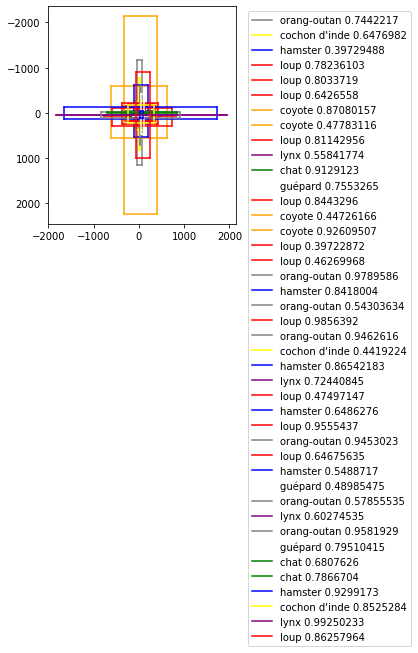

In [15]:
y_pred = model.predict(x_train)
y_pred.shape
y_pred[0].shape
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

In [ ]:
y_pred = model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

In [35]:
# Téléchargement des poids
!wget https://drive.google.com/uc?id=1PtOtf4Du69Sqzj3oYS2nD1mAoz8n1KgZ -O best_weights.index
!wget https://drive.google.com/uc?id=1w9VHJxjOEUIhcJZeUBkIl7ZnTJLYz9kv -O best_weights.data-00000-of-00001

--2021-11-29 17:24:09--  https://drive.google.com/uc?id=1PtOtf4Du69Sqzj3oYS2nD1mAoz8n1KgZ
Resolving drive.google.com (drive.google.com)... 172.217.214.113, 172.217.214.102, 172.217.214.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jfpaltu3v32s0as0bn5vpn0j21d7kea/1638206625000/04558954327840318068/*/1PtOtf4Du69Sqzj3oYS2nD1mAoz8n1KgZ [following]
--2021-11-29 17:24:10--  https://doc-0g-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jfpaltu3v32s0as0bn5vpn0j21d7kea/1638206625000/04558954327840318068/*/1PtOtf4Du69Sqzj3oYS2nD1mAoz8n1KgZ
Resolving doc-0g-1g-docs.googleusercontent.com (doc-0g-1g-docs.googleusercontent.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Connecting to doc-0g-1g-docs.googleusercontent.com (doc-0g-1g-docs.googleusercontent.com)|1

In [36]:
model.load_weights('best_weights')

In [44]:
new_model = Sequential()
new_model.add(model)
new_model.add(Dense(15, activation='linear'))
new_model.add(Reshape((CELL_PER_DIM,CELL_PER_DIM,NB_CLASSES+5)))

558


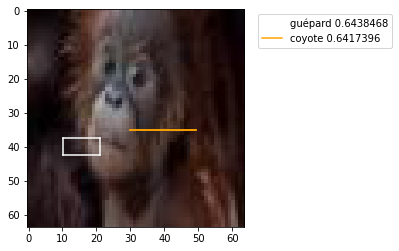

In [48]:
y_pred = new_model.predict(x_train)
print_data_detection(x_train, y_pred, image_size=IMAGE_SIZE, mode='pred')

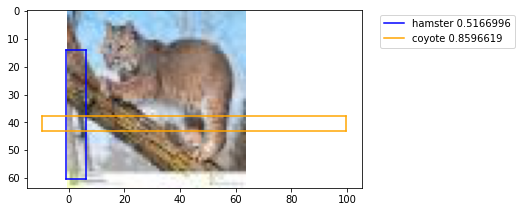

In [46]:
print_data_detection(x_val, y_pred, id=81, image_size=IMAGE_SIZE, mode='pred')